In [24]:
import pandas as pd
import os
from joblib import Parallel, delayed
from tqdm import tqdm
import hashlib
import numpy as np
from esm import pretrained, FastaBatchedDataset
import torch
from joblib import load
import seaborn as sns
import matplotlib.pyplot as plt
import re
import subprocess
from predict import predict_beaker
from predict import get_representations
import warnings
import random
from core import read_dom_table, read_mmseqs_results

In [37]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'

## Download genomes and sequences

In [2]:
def unzip_file(file):
    os.system('gunzip ' + file)


def encode_protein(p):
    return hashlib.sha224(p.encode('utf-8')).hexdigest()


def process_seq(seq, name, assembly, f):
    seq_id = encode_protein(seq)
    print(','.join([name, seq_id, seq, assembly]), file=f)


def process_faa_file(faa_dir, faa_file, out_dir):
    assembly = faa_file.split('.')[0]
    with open(out_dir + assembly + '.csv', 'w') as f:
        seq = ''
        for line in open(faa_dir + faa_file, 'r'):
            if '>' in line:
                if seq:
                    process_seq(seq, name, assembly, f)
                    seq = ''
                name = line.split(' ')[0][1:]
            else:
                seq += line.strip()
        process_seq(seq, name, assembly, f)


def process_unique_split(out_dir, unique_seq_df, i):
    with open(out_dir + str(i) + '.faa', 'w') as f:
        for _, row in unique_seq_df.iterrows():
            print('>' + row['name'], file=f)
            print(row['seq'], file=f)

In [3]:
def hmmsearch(tblout, database, input_file, cutoff=1E-2):
    # fixed total targets for comparison with other 
    rand = random.randint(0, 1_000_000_000)
    os.system(' '.join(['conda run -n beaker', 
                        'hmmsearch',
                        '-o', '../data/tmp/tmpfile_' + str(rand) + '.txt',
                        '--domtblout', tblout,
                        '-E', str(cutoff), 
                        '--domE', str(cutoff),
                        '--cpu', '2',
                        database,
                        input_file]))
    os.system('rm ../data/tmp/tmpfile_' + str(rand) + '.txt')

In [2]:
assemblies_dir = '../data/interim/ecor_assemblies/'

In [4]:
print('Unzipping files')
files = [file for file in os.listdir(assemblies_dir) if '.gz' in file]
_ = Parallel(n_jobs=40)(delayed(unzip_file)(assemblies_dir + f) for f in tqdm(files))

Unzipping files


100%|██████████| 142/142 [00:01<00:00, 82.73it/s]


In [3]:
faa_files = [file for file in os.listdir(assemblies_dir) if '.faa' in file]

In [8]:
seq_assembly_dir = '../data/interim/ecor_assemblies_faa_temp/'
print('Deduplicating fasta files')
os.system('mkdir ' + seq_assembly_dir)
_ = Parallel(n_jobs=40)(delayed(process_faa_file)(assemblies_dir, faa_file, seq_assembly_dir) for faa_file in tqdm(faa_files))
os.system('cat ' + seq_assembly_dir + '*.csv > ../data/interim/ecor_seq_assemblies.csv')
os.system('rm -r ' + seq_assembly_dir)

Deduplicating fasta files


100%|██████████| 69/69 [00:00<00:00, 90.55it/s]


0

In [2]:
seq_assembly_df = pd.read_csv('../data/interim/ecor_seq_assemblies.csv',
                              names=['name', 'seq_id', 'seq', 'assembly'])
unique_seq_df = seq_assembly_df[['name', 'seq']].drop_duplicates()
rm_rows = len(seq_assembly_df) - len(unique_seq_df)
print('Removed', rm_rows, 'of rows (', rm_rows/len(seq_assembly_df)*100, '%)')

Removed 240537 of rows ( 75.09647085268995 %)


In [3]:
len(unique_seq_df)

79767

In [6]:
ecor_unique_seqs_fa = '../data/interim/ecor_unique_seqs.faa'

In [12]:
unique_seq_dir = '../data/interim/ecor_unique_seqs_temp/'
print('Writing deduplicated sequences')
os.mkdir(unique_seq_dir)
unique_seq_df = np.array_split(unique_seq_df, 1_000)
Parallel(n_jobs=40)(delayed(process_unique_split)(unique_seq_dir, df, i) for i, df in tqdm(enumerate(unique_seq_df), total=1_000))
os.system('cat ' + unique_seq_dir + '*.faa > ' + ecor_unique_seqs_fa)
os.system('rm -r ' + unique_seq_dir)

Writing deduplicated sequences


100%|██████████| 1000/1000 [00:00<00:00, 1172.39it/s]


0

## Get representations for sequences

In [7]:
rep_file = '../data/interim/ecor_representations_reps.csv' # output

In [10]:
rep_output_dir = '../data/interim/'
if 'ecor_representations_reps.csv' not in os.listdir('../data/interim'):
    print('Calculating assembly representations')
    model_location = 'esm2_t30_150M_UR50D'
    toks_per_batch = 4096
    truncation_seq_length = 1022
    repr_layer = 30
    model, alphabet = pretrained.load_model_and_alphabet(model_location)
    device = torch.device('cuda')
    print('Model device:', device)
    model = model.to(device)
    repr_layer = (repr_layer + model.num_layers + 1) % (model.num_layers + 1)
    print('Repr layer', repr_layer)
    get_representations('../data/interim/ecor_unique_seqs.faa', 'ecor_representations', 
                        rep_output_dir, toks_per_batch, alphabet,
                        truncation_seq_length, model, repr_layer, 'cuda')
else:
    warnings.warn('Representation directory already exists')

Calculating assembly representations
Model device: cuda
Repr layer 30


100%|██████████| 7495/7495 [27:28<00:00,  4.55it/s]


## Make Beaker Predictions

In [8]:
feature_files = [file for file in os.listdir(assemblies_dir) if '.txt' in file]
fna_files = [file for file in os.listdir(assemblies_dir) if '.fna' in file]

In [9]:
feature_file_dict = {x.split('.')[0]: '../data/interim/ecor_assemblies/' + x for x in feature_files}
fna_file_dict = {x.split('.')[0]: '../data/interim/ecor_assemblies/' + x for x in fna_files}
assemblies = feature_file_dict.keys()

In [4]:
prediction_out_dir = '../data/processed/ecor_predictions/'

In [14]:
if 'ecor_predictions' in os.listdir('../data/processed'):
    os.system('rm -r ' + prediction_out_dir)
os.mkdir(prediction_out_dir) 

In [15]:
for assembly in tqdm(assemblies):
    feature_file = feature_file_dict[assembly]
    fna_file = fna_file_dict[assembly]
    predict_beaker(feature_file, fna_file, 
                   rep_file=rep_file,
                   n_jobs=40, 
                   output_dir=prediction_out_dir, 
                   save_x=True)

  0%|          | 0/69 [00:00<?, ?it/s]

Making predictions for GCF_003334715
Building model matrix


100%|██████████| 4221/4221 [00:06<00:00, 677.53it/s]


Building sequence feature matrix


100%|██████████| 4221/4221 [00:08<00:00, 482.55it/s] 


Making predictions


  1%|▏         | 1/69 [00:38<43:48, 38.65s/it]

Making predictions for GCF_003334035
Building model matrix


100%|██████████| 4353/4353 [00:06<00:00, 643.76it/s]


Building sequence feature matrix


100%|██████████| 4353/4353 [00:03<00:00, 1254.93it/s]


Making predictions


  3%|▎         | 2/69 [01:00<31:54, 28.57s/it]

Making predictions for GCF_003886345
Building model matrix


100%|██████████| 4676/4676 [00:06<00:00, 677.70it/s]


Building sequence feature matrix


100%|██████████| 4676/4676 [00:03<00:00, 1321.23it/s]


Making predictions


  4%|▍         | 3/69 [01:21<27:58, 25.43s/it]

Making predictions for GCF_003886675
Building model matrix


100%|██████████| 4814/4814 [00:06<00:00, 695.62it/s]


Building sequence feature matrix


100%|██████████| 4814/4814 [00:03<00:00, 1285.77it/s]


Making predictions


  6%|▌         | 4/69 [01:43<26:00, 24.00s/it]

Making predictions for GCF_003334145
Building model matrix


100%|██████████| 4175/4175 [00:06<00:00, 670.71it/s]


Building sequence feature matrix


100%|██████████| 4175/4175 [00:03<00:00, 1295.10it/s]


Making predictions


  7%|▋         | 5/69 [02:03<24:03, 22.55s/it]

Making predictions for GCF_003892475
Building model matrix


100%|██████████| 4959/4959 [00:07<00:00, 683.90it/s]


Building sequence feature matrix


100%|██████████| 4959/4959 [00:04<00:00, 1219.58it/s]


Making predictions


  9%|▊         | 6/69 [02:26<23:38, 22.52s/it]

Making predictions for GCF_003333475
Building model matrix


100%|██████████| 4749/4749 [00:07<00:00, 667.92it/s]


Building sequence feature matrix


100%|██████████| 4749/4749 [00:03<00:00, 1215.83it/s]


Making predictions


 10%|█         | 7/69 [02:47<23:01, 22.29s/it]

Making predictions for GCF_003886445
Building model matrix


100%|██████████| 5042/5042 [00:07<00:00, 661.42it/s]


Building sequence feature matrix


100%|██████████| 5042/5042 [00:04<00:00, 1240.73it/s]


Making predictions


 12%|█▏        | 8/69 [03:10<22:49, 22.44s/it]

Making predictions for GCF_003334555
Building model matrix


100%|██████████| 4859/4859 [00:07<00:00, 670.22it/s]


Building sequence feature matrix


100%|██████████| 4859/4859 [00:03<00:00, 1334.02it/s]


Making predictions


 13%|█▎        | 9/69 [03:33<22:24, 22.40s/it]

Making predictions for GCF_003886375
Building model matrix


100%|██████████| 4923/4923 [00:07<00:00, 687.88it/s]


Building sequence feature matrix


100%|██████████| 4923/4923 [00:03<00:00, 1258.63it/s]


Making predictions


 14%|█▍        | 10/69 [03:55<21:54, 22.28s/it]

Making predictions for GCF_003334335
Building model matrix


100%|██████████| 4787/4787 [00:06<00:00, 692.63it/s]


Building sequence feature matrix


100%|██████████| 4787/4787 [00:03<00:00, 1273.37it/s]


Making predictions


 16%|█▌        | 11/69 [04:16<21:17, 22.03s/it]

Making predictions for GCF_003333765
Building model matrix


100%|██████████| 4949/4949 [00:07<00:00, 677.98it/s]


Building sequence feature matrix


100%|██████████| 4949/4949 [00:03<00:00, 1335.23it/s]


Making predictions


 17%|█▋        | 12/69 [04:38<21:01, 22.13s/it]

Making predictions for GCF_003333505
Building model matrix


100%|██████████| 4725/4725 [00:06<00:00, 689.13it/s]


Building sequence feature matrix


100%|██████████| 4725/4725 [00:03<00:00, 1326.42it/s]


Making predictions


 19%|█▉        | 13/69 [05:00<20:33, 22.03s/it]

Making predictions for GCF_003886285
Building model matrix


100%|██████████| 4456/4456 [00:06<00:00, 679.60it/s]


Building sequence feature matrix


100%|██████████| 4456/4456 [00:03<00:00, 1351.07it/s]


Making predictions


 20%|██        | 14/69 [05:21<19:48, 21.61s/it]

Making predictions for GCF_003333715
Building model matrix


100%|██████████| 4582/4582 [00:06<00:00, 678.09it/s]


Building sequence feature matrix


100%|██████████| 4582/4582 [00:03<00:00, 1299.71it/s]


Making predictions


 22%|██▏       | 15/69 [05:42<19:23, 21.54s/it]

Making predictions for GCF_003333785
Building model matrix


100%|██████████| 4838/4838 [00:07<00:00, 690.27it/s]


Building sequence feature matrix


100%|██████████| 4838/4838 [00:03<00:00, 1343.73it/s]


Making predictions


 23%|██▎       | 16/69 [06:04<19:04, 21.60s/it]

Making predictions for GCF_003333925
Building model matrix


100%|██████████| 4433/4433 [00:06<00:00, 689.19it/s]


Building sequence feature matrix


100%|██████████| 4433/4433 [00:03<00:00, 1314.49it/s]


Making predictions


 25%|██▍       | 17/69 [06:24<18:24, 21.25s/it]

Making predictions for GCF_003886695
Building model matrix


100%|██████████| 4822/4822 [00:07<00:00, 670.13it/s]


Building sequence feature matrix


100%|██████████| 4822/4822 [00:03<00:00, 1285.13it/s]


Making predictions


 26%|██▌       | 18/69 [06:46<18:10, 21.39s/it]

Making predictions for GCF_003334175
Building model matrix


100%|██████████| 4105/4105 [00:06<00:00, 668.30it/s]


Building sequence feature matrix


100%|██████████| 4105/4105 [00:03<00:00, 1259.32it/s]


Making predictions


 28%|██▊       | 19/69 [07:06<17:31, 21.03s/it]

Making predictions for GCF_003333605
Building model matrix


100%|██████████| 4694/4694 [00:06<00:00, 680.75it/s]


Building sequence feature matrix


100%|██████████| 4694/4694 [00:03<00:00, 1360.95it/s]


Making predictions


 29%|██▉       | 20/69 [07:28<17:18, 21.19s/it]

Making predictions for GCF_003885255
Building model matrix


100%|██████████| 4742/4742 [00:07<00:00, 669.96it/s]


Building sequence feature matrix


100%|██████████| 4742/4742 [00:03<00:00, 1395.16it/s]


Making predictions


 30%|███       | 21/69 [07:50<17:05, 21.37s/it]

Making predictions for GCF_003333675
Building model matrix


100%|██████████| 5240/5240 [00:07<00:00, 683.76it/s]


Building sequence feature matrix


100%|██████████| 5240/5240 [00:04<00:00, 1250.36it/s]


Making predictions


 32%|███▏      | 22/69 [08:13<17:10, 21.92s/it]

Making predictions for GCF_003334625
Building model matrix


100%|██████████| 4571/4571 [00:06<00:00, 653.63it/s]


Building sequence feature matrix


100%|██████████| 4571/4571 [00:03<00:00, 1293.70it/s]


Making predictions


 33%|███▎      | 23/69 [08:34<16:37, 21.69s/it]

Making predictions for GCF_003334425
Building model matrix


100%|██████████| 4390/4390 [00:06<00:00, 673.39it/s]


Building sequence feature matrix


100%|██████████| 4390/4390 [00:03<00:00, 1338.91it/s]


Making predictions


 35%|███▍      | 24/69 [08:55<16:01, 21.36s/it]

Making predictions for GCF_003886455
Building model matrix


100%|██████████| 4567/4567 [00:06<00:00, 688.37it/s]


Building sequence feature matrix


100%|██████████| 4567/4567 [00:03<00:00, 1254.76it/s]


Making predictions


 36%|███▌      | 25/69 [09:15<15:33, 21.22s/it]

Making predictions for GCF_003334245
Building model matrix


100%|██████████| 4848/4848 [00:07<00:00, 667.47it/s]


Building sequence feature matrix


100%|██████████| 4848/4848 [00:03<00:00, 1320.10it/s]


Making predictions


 38%|███▊      | 26/69 [09:38<15:24, 21.49s/it]

Making predictions for GCF_003334585
Building model matrix


100%|██████████| 4854/4854 [00:07<00:00, 684.03it/s]


Building sequence feature matrix


100%|██████████| 4854/4854 [00:03<00:00, 1221.84it/s]


Making predictions


 39%|███▉      | 27/69 [10:00<15:11, 21.70s/it]

Making predictions for GCF_003334155
Building model matrix


100%|██████████| 4226/4226 [00:06<00:00, 648.95it/s]


Building sequence feature matrix


100%|██████████| 4226/4226 [00:03<00:00, 1271.56it/s]


Making predictions


 41%|████      | 28/69 [10:20<14:32, 21.27s/it]

Making predictions for GCF_003333935
Building model matrix


100%|██████████| 4445/4445 [00:06<00:00, 654.74it/s]


Building sequence feature matrix


100%|██████████| 4445/4445 [00:03<00:00, 1279.61it/s]


Making predictions


 42%|████▏     | 29/69 [10:41<14:06, 21.16s/it]

Making predictions for GCF_003334815
Building model matrix


100%|██████████| 4552/4552 [00:07<00:00, 648.83it/s]


Building sequence feature matrix


100%|██████████| 4552/4552 [00:03<00:00, 1269.22it/s]


Making predictions


 43%|████▎     | 30/69 [11:03<13:50, 21.29s/it]

Making predictions for GCF_003333565
Building model matrix


100%|██████████| 4565/4565 [00:06<00:00, 683.18it/s]


Building sequence feature matrix


100%|██████████| 4565/4565 [00:03<00:00, 1171.66it/s]


Making predictions


 45%|████▍     | 31/69 [11:24<13:27, 21.26s/it]

Making predictions for GCF_003334115
Building model matrix


100%|██████████| 4143/4143 [00:06<00:00, 682.28it/s]


Building sequence feature matrix


100%|██████████| 4143/4143 [00:03<00:00, 1191.51it/s]


Making predictions


 46%|████▋     | 32/69 [11:44<12:51, 20.84s/it]

Making predictions for GCF_003333435
Building model matrix


100%|██████████| 4342/4342 [00:06<00:00, 697.87it/s]


Building sequence feature matrix


100%|██████████| 4342/4342 [00:03<00:00, 1264.57it/s]


Making predictions


 48%|████▊     | 33/69 [12:04<12:23, 20.66s/it]

Making predictions for GCF_003334305
Building model matrix


100%|██████████| 4483/4483 [00:06<00:00, 684.55it/s]


Building sequence feature matrix


100%|██████████| 4483/4483 [00:03<00:00, 1234.57it/s]


Making predictions


 49%|████▉     | 34/69 [12:25<12:03, 20.68s/it]

Making predictions for GCF_003334165
Building model matrix


100%|██████████| 4205/4205 [00:06<00:00, 681.91it/s]


Building sequence feature matrix


100%|██████████| 4205/4205 [00:03<00:00, 1333.83it/s]


Making predictions


 51%|█████     | 35/69 [12:44<11:34, 20.43s/it]

Making predictions for GCF_003334785
Building model matrix


100%|██████████| 4327/4327 [00:06<00:00, 670.15it/s]


Building sequence feature matrix


100%|██████████| 4327/4327 [00:03<00:00, 1327.38it/s]


Making predictions


 52%|█████▏    | 36/69 [13:05<11:15, 20.47s/it]

Making predictions for GCF_003892555
Building model matrix


100%|██████████| 4695/4695 [00:07<00:00, 658.28it/s]


Building sequence feature matrix


100%|██████████| 4695/4695 [00:03<00:00, 1341.15it/s]


Making predictions


 54%|█████▎    | 37/69 [13:27<11:06, 20.83s/it]

Making predictions for GCF_003333545
Building model matrix


100%|██████████| 4818/4818 [00:07<00:00, 685.62it/s]


Building sequence feature matrix


100%|██████████| 4818/4818 [00:03<00:00, 1269.91it/s]


Making predictions


 55%|█████▌    | 38/69 [13:48<10:54, 21.10s/it]

Making predictions for GCF_003886135
Building model matrix


100%|██████████| 5163/5163 [00:07<00:00, 678.32it/s]


Building sequence feature matrix


100%|██████████| 5163/5163 [00:04<00:00, 1251.16it/s]


Making predictions


 57%|█████▋    | 39/69 [14:11<10:47, 21.59s/it]

Making predictions for GCF_003334235
Building model matrix


100%|██████████| 4234/4234 [00:06<00:00, 685.10it/s]


Building sequence feature matrix


100%|██████████| 4234/4234 [00:03<00:00, 1281.84it/s]


Making predictions


 58%|█████▊    | 40/69 [14:31<10:11, 21.09s/it]

Making predictions for GCF_003886535
Building model matrix


100%|██████████| 4801/4801 [00:07<00:00, 680.48it/s]


Building sequence feature matrix


100%|██████████| 4801/4801 [00:03<00:00, 1223.48it/s]


Making predictions


 59%|█████▉    | 41/69 [14:53<09:55, 21.26s/it]

Making predictions for GCF_003892645
Building model matrix


100%|██████████| 4904/4904 [00:07<00:00, 673.77it/s]


Building sequence feature matrix


100%|██████████| 4904/4904 [00:03<00:00, 1264.99it/s]


Making predictions


 61%|██████    | 42/69 [15:15<09:40, 21.49s/it]

Making predictions for GCF_003334015
Building model matrix


100%|██████████| 4583/4583 [00:06<00:00, 675.67it/s]


Building sequence feature matrix


100%|██████████| 4583/4583 [00:03<00:00, 1204.94it/s]


Making predictions


 62%|██████▏   | 43/69 [15:36<09:15, 21.35s/it]

Making predictions for GCF_003334675
Building model matrix


100%|██████████| 4235/4235 [00:06<00:00, 684.44it/s]


Building sequence feature matrix


100%|██████████| 4235/4235 [00:03<00:00, 1191.96it/s]


Making predictions


 64%|██████▍   | 44/69 [15:56<08:44, 20.97s/it]

Making predictions for GCF_003334355
Building model matrix


100%|██████████| 4212/4212 [00:06<00:00, 670.91it/s]


Building sequence feature matrix


100%|██████████| 4212/4212 [00:03<00:00, 1175.12it/s]


Making predictions


 65%|██████▌   | 45/69 [16:16<08:16, 20.70s/it]

Making predictions for GCF_003333385
Building model matrix


100%|██████████| 4533/4533 [00:06<00:00, 674.68it/s]


Building sequence feature matrix


100%|██████████| 4533/4533 [00:03<00:00, 1251.76it/s]


Making predictions


 67%|██████▋   | 46/69 [16:37<07:56, 20.72s/it]

Making predictions for GCF_003333855
Building model matrix


100%|██████████| 4935/4935 [00:07<00:00, 677.90it/s]


Building sequence feature matrix


100%|██████████| 4935/4935 [00:04<00:00, 1223.17it/s]


Making predictions


 68%|██████▊   | 47/69 [16:59<07:44, 21.11s/it]

Making predictions for GCF_003892435
Building model matrix


100%|██████████| 4939/4939 [00:07<00:00, 680.51it/s]


Building sequence feature matrix


100%|██████████| 4939/4939 [00:03<00:00, 1268.98it/s]


Making predictions


 70%|██████▉   | 48/69 [17:21<07:30, 21.43s/it]

Making predictions for GCF_003885215
Building model matrix


100%|██████████| 5144/5144 [00:07<00:00, 671.38it/s]


Building sequence feature matrix


100%|██████████| 5144/5144 [00:03<00:00, 1302.48it/s]


Making predictions


 71%|███████   | 49/69 [17:44<07:17, 21.86s/it]

Making predictions for GCF_003334665
Building model matrix


100%|██████████| 4587/4587 [00:06<00:00, 691.01it/s]


Building sequence feature matrix


100%|██████████| 4587/4587 [00:03<00:00, 1265.78it/s]


Making predictions


 72%|███████▏  | 50/69 [18:04<06:49, 21.53s/it]

Making predictions for GCF_003333425
Building model matrix


100%|██████████| 4666/4666 [00:06<00:00, 691.30it/s]


Building sequence feature matrix


100%|██████████| 4666/4666 [00:03<00:00, 1293.45it/s]


Making predictions


 74%|███████▍  | 51/69 [18:26<06:24, 21.39s/it]

Making predictions for GCF_003333945
Building model matrix


100%|██████████| 4860/4860 [00:07<00:00, 689.30it/s]


Building sequence feature matrix


100%|██████████| 4860/4860 [00:03<00:00, 1288.33it/s]


Making predictions


 75%|███████▌  | 52/69 [18:47<06:05, 21.48s/it]

Making predictions for GCF_003333795
Building model matrix


100%|██████████| 4880/4880 [00:07<00:00, 680.24it/s]


Building sequence feature matrix


100%|██████████| 4880/4880 [00:03<00:00, 1249.16it/s]


Making predictions


 77%|███████▋  | 53/69 [19:09<05:44, 21.55s/it]

Making predictions for GCF_003333495
Building model matrix


100%|██████████| 4508/4508 [00:06<00:00, 672.58it/s]


Building sequence feature matrix


100%|██████████| 4508/4508 [00:03<00:00, 1229.12it/s]


Making predictions


 78%|███████▊  | 54/69 [19:30<05:20, 21.34s/it]

Making predictions for GCF_003334705
Building model matrix


100%|██████████| 4580/4580 [00:06<00:00, 690.92it/s]


Building sequence feature matrix


100%|██████████| 4580/4580 [00:03<00:00, 1238.65it/s]


Making predictions


 80%|███████▉  | 55/69 [19:51<04:56, 21.21s/it]

Making predictions for GCF_003334765
Building model matrix


100%|██████████| 4493/4493 [00:06<00:00, 688.97it/s]


Building sequence feature matrix


100%|██████████| 4493/4493 [00:03<00:00, 1238.26it/s]


Making predictions


 81%|████████  | 56/69 [20:11<04:33, 21.01s/it]

Making predictions for GCF_003333845
Building model matrix


100%|██████████| 4830/4830 [00:07<00:00, 677.96it/s]


Building sequence feature matrix


100%|██████████| 4830/4830 [00:03<00:00, 1250.41it/s]


Making predictions


 83%|████████▎ | 57/69 [20:33<04:14, 21.21s/it]

Making predictions for GCF_003892355
Building model matrix


100%|██████████| 4825/4825 [00:07<00:00, 688.85it/s]


Building sequence feature matrix


100%|██████████| 4825/4825 [00:03<00:00, 1254.23it/s]


Making predictions


 84%|████████▍ | 58/69 [20:54<03:54, 21.28s/it]

Making predictions for GCF_003886115
Building model matrix


100%|██████████| 4736/4736 [00:07<00:00, 672.49it/s]


Building sequence feature matrix


100%|██████████| 4736/4736 [00:03<00:00, 1248.20it/s]


Making predictions


 86%|████████▌ | 59/69 [21:16<03:33, 21.31s/it]

Making predictions for GCF_003333975
Building model matrix


100%|██████████| 4512/4512 [00:06<00:00, 677.71it/s]


Building sequence feature matrix


100%|██████████| 4512/4512 [00:03<00:00, 1205.40it/s]


Making predictions


 87%|████████▋ | 60/69 [21:36<03:10, 21.15s/it]

Making predictions for GCF_003886035
Building model matrix


100%|██████████| 4461/4461 [00:06<00:00, 698.79it/s]


Building sequence feature matrix


100%|██████████| 4461/4461 [00:03<00:00, 1250.82it/s]


Making predictions


 88%|████████▊ | 61/69 [21:57<02:47, 20.97s/it]

Making predictions for GCF_003334605
Building model matrix


100%|██████████| 4868/4868 [00:07<00:00, 668.49it/s]


Building sequence feature matrix


100%|██████████| 4868/4868 [00:04<00:00, 1207.91it/s]


Making predictions


 90%|████████▉ | 62/69 [22:19<02:29, 21.29s/it]

Making predictions for GCF_003333685
Building model matrix


100%|██████████| 4899/4899 [00:07<00:00, 682.68it/s]


Building sequence feature matrix


100%|██████████| 4899/4899 [00:04<00:00, 1201.85it/s]


Making predictions


 91%|█████████▏| 63/69 [22:41<02:08, 21.47s/it]

Making predictions for GCF_003333645
Building model matrix


100%|██████████| 4543/4543 [00:06<00:00, 676.38it/s]


Building sequence feature matrix


100%|██████████| 4543/4543 [00:03<00:00, 1240.97it/s]


Making predictions


 93%|█████████▎| 64/69 [23:02<01:46, 21.31s/it]

Making predictions for GCF_003334525
Building model matrix


100%|██████████| 4722/4722 [00:06<00:00, 689.56it/s]


Building sequence feature matrix


100%|██████████| 4722/4722 [00:03<00:00, 1219.22it/s]


Making predictions


 94%|█████████▍| 65/69 [23:23<01:25, 21.33s/it]

Making predictions for GCF_003334775
Building model matrix


100%|██████████| 4802/4802 [00:06<00:00, 697.53it/s]


Building sequence feature matrix


100%|██████████| 4802/4802 [00:04<00:00, 1193.19it/s]


Making predictions


 96%|█████████▌| 66/69 [23:45<01:04, 21.38s/it]

Making predictions for GCF_003334005
Building model matrix


100%|██████████| 4598/4598 [00:06<00:00, 688.10it/s]


Building sequence feature matrix


100%|██████████| 4598/4598 [00:03<00:00, 1227.78it/s]


Making predictions


 97%|█████████▋| 67/69 [24:06<00:42, 21.27s/it]

Making predictions for GCF_003886495
Building model matrix


100%|██████████| 5335/5335 [00:07<00:00, 679.15it/s]


Building sequence feature matrix


100%|██████████| 5335/5335 [00:03<00:00, 1345.44it/s]


Making predictions


 99%|█████████▊| 68/69 [24:29<00:21, 21.83s/it]

Making predictions for GCF_003334085
Building model matrix


100%|██████████| 4784/4784 [00:06<00:00, 690.25it/s]


Building sequence feature matrix


100%|██████████| 4784/4784 [00:03<00:00, 1244.08it/s]


Making predictions


100%|██████████| 69/69 [24:50<00:00, 21.61s/it]


In [5]:
predictions = pd.concat([pd.read_csv(prediction_out_dir + f) for 
                         f in tqdm(os.listdir(prediction_out_dir)) if '.csv' in f])

100%|██████████| 138/138 [00:12<00:00, 11.46it/s]


In [6]:
(predictions['beaker_prediction'] > 0.5).sum()

4603

## Search ecor collection for homologs of known systems

In [16]:
def run_defense_finder(assembly_file, out_dir):
    assembly_stub = assembly_file.split('.')[0]
    assembly_out_dir = out_dir + assembly_stub
    os.mkdir(assembly_out_dir)
    subprocess.run(['conda',
                    'run',
                    '-n',
                    'beaker',
                    'defense-finder', 'run', 
                    '-w', '1',
                    '-o', assembly_out_dir,
                    '../data/interim/ecor_assembly_faa/' + assembly_file], 
                   stdout=subprocess.DEVNULL)

In [13]:
faa_dir = '../data/interim/ecor_assembly_faa/'

In [9]:
os.mkdir(faa_dir)

In [12]:
for f in faa_files:
    os.system('cp ../data/interim/ecor_assemblies/' + f + ' ' + faa_dir)

In [14]:
ecor_df_dir = '../data/interim/ecor_defense_finder_results/'

In [17]:
_ = Parallel(n_jobs=40)(delayed(run_defense_finder)
                        (f, ecor_df_dir) 
                         for f in tqdm(assembly_files))

100%|██████████| 71/71 [00:04<00:00, 15.21it/s]


In [7]:
defense_finder_results_dir = [x for x in os.listdir('../data/interim/ecor_defense_finder_results/') if 'GCF' in x]


In [8]:
defense_genes_list = []
defense_hmmer_list = []
for assembly in tqdm(defense_finder_results_dir):
    genes_df = pd.read_csv('../data/interim/ecor_defense_finder_results/' + assembly + '/' + 'defense_finder_genes.tsv', 
                           sep='\t')
    genes_df['assembly'] = assembly
    defense_genes_list.append(genes_df)
    hmmer_df = pd.read_csv('../data/interim/ecor_defense_finder_results/' + assembly + '/' + 'defense_finder_hmmer.tsv', 
                           sep='\t')
    hmmer_df['assembly'] = assembly
    defense_hmmer_list.append(hmmer_df)


100%|██████████| 69/69 [00:05<00:00, 12.10it/s]


In [9]:
defense_finder_homologs = pd.concat(defense_hmmer_list)
defense_finder_homologs['protein_assembly'] = defense_finder_homologs['hit_id'] + '_' + defense_finder_homologs['assembly']
unique_defense_finder_homologs = defense_finder_homologs['protein_assembly'].unique()
dedup_defense_finder_homolog_df = (defense_finder_homologs.groupby('protein_assembly')
                                   .agg(defense_homolog_names=('gene_name', lambda x: ', '.join(x)))
                                   .reset_index())

In [10]:
defense_finder_systems = pd.concat(defense_genes_list)
defense_finder_systems['protein_assembly'] = defense_finder_systems['hit_id'] + '_' + defense_finder_systems['assembly']
unique_defense_finder_systems = defense_finder_systems['protein_assembly'].unique()
breif_defense_finder_systems = defense_finder_systems[['protein_assembly', 'sys_id']]

In [26]:
merged_predictions = predictions
merged_predictions['assembly_stub'] = merged_predictions['assembly'].str.split('.', expand=True)[0]
merged_predictions['protein_assembly'] = merged_predictions['product_accession'] + '_' + merged_predictions['assembly_stub']
merged_predictions['defense_homolog'] = merged_predictions['protein_assembly'].isin(unique_defense_finder_homologs)
merged_predictions['defense_system_protein'] = merged_predictions['protein_assembly'].isin(unique_defense_finder_systems)
merged_predictions = (merged_predictions.merge(dedup_defense_finder_homolog_df, how='left', 
                                               on='protein_assembly')
                      .merge(breif_defense_finder_systems, how='left', on='protein_assembly'))


<Axes: xlabel='beaker_prediction', ylabel='Count'>

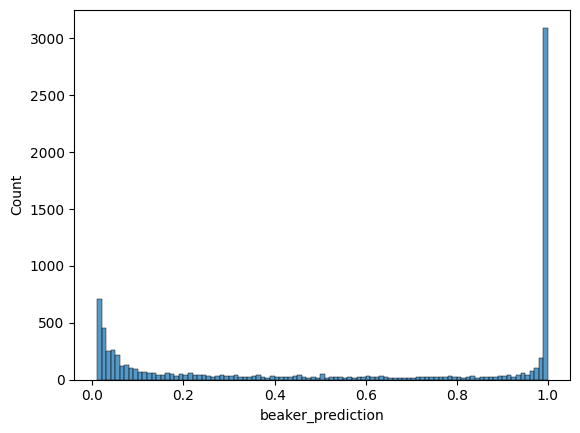

In [39]:
sns.histplot(merged_predictions.loc[merged_predictions['beaker_prediction'] > 0.01,'beaker_prediction'], binwidth=0.01)

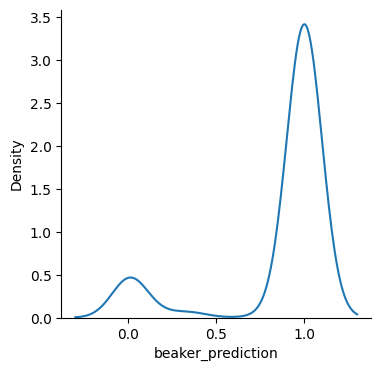

In [40]:
plt.subplots(figsize=(4,4))
sns.kdeplot(data=merged_predictions[merged_predictions['defense_system_protein']], x='beaker_prediction')
sns.despine()

In [41]:
((merged_predictions['beaker_prediction'] > 0.5) &
 (~merged_predictions['defense_homolog'])).sum()

2264

## Define operons by runs seperated by <30 bp on the same strand

In [42]:
sorted_predictions = merged_predictions.sort_values(['genomic_accession', 'start'], ascending=True)

In [43]:
max_gap = 30
first = True
operon_list = []
for _, row in tqdm(sorted_predictions.iterrows(), 
                   total=len(sorted_predictions),
                   position=0):
    curr_start = row['start']
    curr_accession = row['genomic_accession']
    curr_strand = row['strand']
    if first:
        operon = curr_accession + '|' + str(curr_start) + '|' + curr_strand
        first = False
    else:
        if (((curr_start - prev_end) > max_gap) or 
            (curr_accession != prev_accession) or 
            (curr_strand != prev_strand)):
            operon = curr_accession + '|' + str(curr_start) + '|' + curr_strand
    operon_list.append(operon)
    prev_end = row['end']
    prev_accession = row['genomic_accession']
    prev_strand = row['strand']
    

100%|██████████| 321347/321347 [00:18<00:00, 17448.62it/s]


In [44]:
sorted_predictions['operon'] = operon_list

## Mark operons at the edge of each contig

In [45]:
sorted_predictions['contig_end'] = (sorted_predictions.groupby('genomic_accession')
                                    .apply(lambda df: (df['start'] == df['start'].min()) | 
                                               (df['end'] == df['end'].max()))
                                    .reset_index(level=0, drop=True))

## Cluster proteins into homologous groups

In [39]:
conda_commands = ['conda', 'run', '-n', 'beaker']

In [48]:
target = ecor_unique_seqs_fa
target_db = '../data/interim/mmseqs_working_dir/ecor_unique_seqs_db'
out_db = '../data/interim/mmseqs_working_dir/ecor_unique_seqs_db_clust'
out_tsv = '../data/interim/ecor_clusters.tsv'
threads = str(40)

In [52]:
os.system(' '.join(conda_commands +
                   ['mmseqs createdb ' + target + ' ' + target_db + ' --dbtype 1']))

createdb ../data/interim/ecor_unique_seqs.faa ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db --dbtype 1 

MMseqs Version:       	13.45111
Database type         	1
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[=======
Time for merging to ecor_unique_seqs_db_h: 0h 0m 0s 140ms
Time for merging to ecor_unique_seqs_db: 0h 0m 0s 184ms
Database type: Aminoacid
Time for processing: 0h 0m 1s 27ms



0

In [53]:
os.system(' '.join(conda_commands +
                   ['mmseqs createindex ' + target_db + ' ../data/tmp']))

createindex ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db ../data/tmp 

MMseqs Version:          	13.45111
Seed substitution matrix 	nucl:nucleotide.out,aa:VTML80.out
k-mer length             	0
Alphabet size            	nucl:5,aa:21
Compositional bias       	1
Max sequence length      	65535
Max results per query    	300
Mask residues            	1
Mask lower case residues 	0
Spaced k-mers            	1
Spaced k-mer pattern     	
Sensitivity              	7.5
k-score                  	0
Check compatible         	0
Search type              	0
Split database           	0
Split memory limit       	0
Verbosity                	3
Threads                  	96
Min codons in orf        	30
Max codons in length     	32734
Max orf gaps             	2147483647
Contig start mode        	2
Contig end mode          	2
Orf start mode           	1
Forward frames           	1,2,3
Reverse frames           	1,2,3
Translation table        	1
Translate orf            	0
Use all table starts     	f

0

In [54]:
os.system(' '.join(conda_commands +
                   ['mmseqs linclust ' + target_db + ' ' +
          out_db + ' ' +
          '../data/tmp ' +
          '-c 0.8 '
          '--min-seq-id 0.3 '
          '--threads ' + threads + ' ' +
          '--cluster-mode 1']))  # connected components

linclust ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db_clust ../data/tmp -c 0.8 --min-seq-id 0.3 --threads 48 --cluster-mode 1 

MMseqs Version:                     	13.45111
Cluster mode                        	1
Max connected component depth       	1000
Similarity type                     	2
Threads                             	48
Compressed                          	0
Verbosity                           	3
Substitution matrix                 	nucl:nucleotide.out,aa:blosum62.out
Add backtrace                       	false
Alignment mode                      	2
Alignment mode                      	0
Allow wrapped scoring               	false
E-value threshold                   	0.001
Seq. id. threshold                  	0.3
Min alignment length                	0
Seq. id. mode                       	0
Alternative alignments              	0
Coverage threshold                  	0.8
Coverage mode                       	0
Max s

0

In [55]:
os.system(' '.join(conda_commands + 
                   ['mmseqs createtsv ' + target_db + ' ' +
          target_db + ' ' +
          out_db + ' ' +
          out_tsv]))

createtsv ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db_clust ../data/interim/ecor_clusters.tsv 

MMseqs Version:                 	13.45111
First sequence as representative	false
Target column                   	1
Add full header                 	false
Sequence source                 	0
Database output                 	false
Threads                         	96
Compressed                      	0
Verbosity                       	3

Time for merging to ecor_clusters.tsv: 0h 0m 0s 542ms
Time for processing: 0h 0m 1s 192ms



0

In [49]:
clusters = pd.read_table(out_tsv, 
                         names=['cluster_id', 'product_accession'])

In [50]:
cluster_merged_preds = (sorted_predictions.merge(clusters, how='inner', 
                                                    on='product_accession'))

## Remove close homologs in MG1655 (>90% ID and coverage)


In [51]:
working_dir = '../data/interim/mmseqs_working_dir/'
mg1655_query = '../data/external/GCF_000005845.2_ASM584v2_protein.faa'
mg1655_db = working_dir + 'mg1655_db'


In [ ]:
os.system(' '.join(conda_commands + 
                   ['mmseqs createdb', 
                    mg1655_query, mg1655_db]))

In [52]:
ecor_seqs_db = '../data/interim/mmseqs_working_dir/ecor_unique_seqs_db'
ecor_mg_search_out = '../data/interim/mmseqs_working_dir/ecor_mg1655_search'

In [ ]:
os.system(' '.join(conda_commands +
                   ['mmseqs',
                    'search',
                    ecor_seqs_db,
                    mg1655_db, 
                    ecor_mg_search_out, 
                    '../data/tmp',
                    '--threads 48',
                    '-a']))

In [53]:
ecor_mg_search_final_out = '../data/interim/ecor_mg_homologs.txt'

In [ ]:
os.system(' '.join(conda_commands +
          ['mmseqs convertalis', 
           ecor_seqs_db, 
           mg1655_db, 
           ecor_mg_search_out, 
           ecor_mg_search_final_out,
           '--threads 48', 
           '--format-output query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov']))

In [54]:
ecor_mg_homolog_df = read_mmseqs_results(ecor_mg_search_final_out)

In [55]:
close_homolog_df = ecor_mg_homolog_df[(ecor_mg_homolog_df['fident'] > 0.9) & 
                                      (ecor_mg_homolog_df['qcov'] > 0.9)]


In [56]:
ecor_mg1655_close_homologs = close_homolog_df['query'].unique()
len(ecor_mg1655_close_homologs)


49684

In [57]:
cluster_merged_preds['MG1655_homolog'] = cluster_merged_preds['product_accession'].isin(ecor_mg1655_close_homologs)

## Output

In [58]:
cluster_merged_preds.to_csv('../data/interim/ecor_predictions.csv', index=False)

In [60]:
cluster_merged_preds.shape

(321347, 32)